# Машинное обучение, ФКН ВШЭ

## Практическое задание 2. Exploratory Data Analysis и линейная регрессия

### Общая информация
Дата выдачи: 05.10.2023

Мягкий дедлайн: 23:59MSK 18.10.2023

Жесткий дедлайн: 23:59MSK 22.10.2022

### О задании
В этом задании мы попытаемся научиться анализировать данные и выделять из них полезные признаки. Мы также научимся пользоваться `seaborn` и `sklearn`, а заодно привыкнем к основным понятиям машинного обучения.

### Оценивание и штрафы
Каждая из задач имеет определенную «стоимость» (указана в скобках около задачи). Максимально допустимая оценка за работу — 10 баллов. Проверяющий имеет право снизить оценку за неэффективную реализацию или неопрятные графики.

**Обратите внимание**, что в каждом разделе домашнего задания есть оцениваниемые задачи и есть вопросы. Вопросы дополняют задачи и направлены на то, чтобы проинтерпретировать или обосновать происходящее. Код без интерпретации не имеет смысла, поэтому отвечать на вопросы обязательно — за отсутствие ответов мы будем снижать баллы за задачи. Если вы ответите на вопросы, но не напишете корректный код к соответствующим оцениваемым задачам, то баллы за такое выставлены не будут.

Сдавать задание после указанного срока сдачи нельзя. При выставлении неполного балла за задание в связи с наличием ошибок на усмотрение проверяющего предусмотрена возможность исправить работу на указанных в ответном письме условиях.

Задание выполняется самостоятельно. «Похожие» решения считаются плагиатом и все задействованные студенты (в том числе те, у кого списали) не могут получить за него больше 0 баллов (подробнее о плагиате см. на странице курса). Если вы нашли решение какого-то из заданий (или его часть) в открытом источнике, необходимо указать ссылку на этот источник в отдельном блоке в конце вашей работы (скорее всего вы будете не единственным, кто это нашел, поэтому чтобы исключить подозрение в плагиате, необходима ссылка на источник).

### Формат сдачи
Задания сдаются через систему Anytask. Инвайт можно найти на странице курса. Присылать необходимо ноутбук с выполненным заданием. Сам ноутбук называйте в формате homework-practice-02-linregr-Username.ipynb, где Username — ваша фамилия.

Для удобства проверки самостоятельно посчитайте свою максимальную оценку (исходя из набора решенных задач) и укажите ниже.

Оценка: 6.

В этом ноутбуке используется библиотека `folium` для визуализации карт. Она работает в google colab!

In [ ]:
import folium

m = folium.Map(location=(55.7522200, 37.6155600), zoom_start=10)

#красиво

Если вы всё сделали правильно, то выше должна открыться карта Москвы.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set(style='darkgrid')

np.random.seed(0)

## Часть 0. Подготовка (1 балл)

**Задание 1 (1 балл)**. Мы будем работать с данными из соревнования [New York City Taxi Trip Duration](https://www.kaggle.com/c/nyc-taxi-trip-duration/overview), в котором нужно было предсказать длительность поездки на такси. Скачайте обучающую выборку из этого соревнования и загрузите ее:

In [ ]:
df = pd.read_csv('train.csv')

In [ ]:
df = df.sample(n = 80001, random_state=1)

In [ ]:
df.shape

(80001, 11)

In [ ]:
df.dtypes

id                     object
vendor_id               int64
pickup_datetime        object
dropoff_datetime       object
passenger_count         int64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
store_and_fwd_flag     object
trip_duration           int64
dtype: object

Обратите внимание на колонки `pickup_datetime` и `dropoff_datetime`. `dropoff_datetime` был добавлена организаторами только в обучающую выборку, то есть использовать эту колонку нельзя, давайте удалим ее. В `pickup_datetime` записаны дата и время начала поездки. Чтобы с ней было удобно работать, давайте преобразуем даты в `datetime`-объекты

In [ ]:
df = df.dropna()

In [ ]:
y = df['trip_duration']
X = df.drop(['dropoff_datetime', 'trip_duration'], axis = 1)

In [ ]:
X.shape

(80001, 9)

In [ ]:
time_str = X['pickup_datetime']

In [ ]:
X['pickup_datetime'] = pd.to_datetime(X['pickup_datetime'])

В колонке `trip_duration` записано целевое значение, которое мы хотим предсказывать. Давайте посмотрим на распределение таргета в обучающей выборке. Для этого нарисуйте его гистограмму:

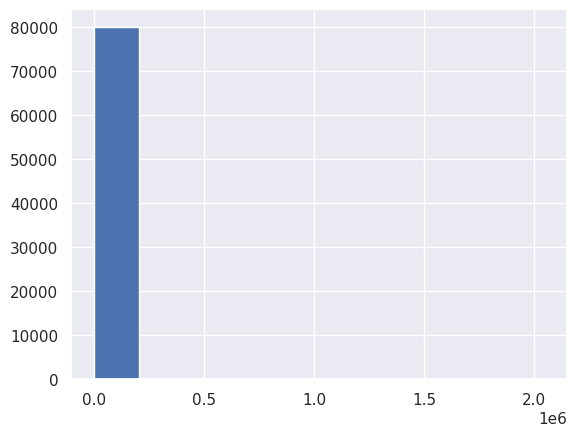

In [ ]:
plt.hist(y)
plt.show()

**Вопрос**: Что можно сказать о целевой переменной по гистограмме её значений?

In [ ]:
# Есть выбросы, которые портят картину
# А еще данные напоминают бурдж-халифа

# Привет из будущего!!! Это ЛоГнОрМалЬнОе распределение, из названия становится
# понятно, в каком направлении мы будем двигаться дальше

В соревновании в качестве метрики качества использовалось RMSLE:
$$\text{RMSLE}(X, y, a) = \sqrt{\frac{1}{\ell}\sum_{i=1}^{\ell} \big(\log{(y_i + 1)} - \log{(a(x_i) + 1)}\big)^2}$$

**Вопрос**: Как вы думаете, почему авторы соревнования выбрали именно RMSLE, а не RMSE?

In [ ]:
# Разность логарифмов меньше штрафует за большие отклонения, чем MSE,
# но при этом ее легче оптимизировать, чем МАЕ

На семинаре мы рассматривали несколько моделей линейной регрессии в `sklearn`, но каждая из них оптимизировала среднеквадратичную ошибку (MSE), а не RMSLE. Давайте проделаем следующий трюк: будем предсказывать не целевую переменную, а ее *логарифм*. Обозначим $\hat{y}_i = \log{(y_i + 1)}$ — модифицированный таргет, а $\hat{a}(x_i)$ — предсказание модели, которая обучалась на $\hat{y}_i$, то есть логарифм таргета. Чтобы предсказать исходное значение, мы можем просто взять экспоненту от нашего предсказания: $a(x_i) = \exp(\hat{a}(x_i)) - 1$.

**Вопрос**: Покажите, что оптимизация RMSLE для модели $a$ эквивалентна оптимизации MSE для модели $\hat{a}$.


In [ ]:
# Доказательство: ╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

# Взятие корня от неотрицательной ошибки - монотонное преобразование, так что
# оптимизация RMSLE эквивалентна оптимизации MSLE

$\log{(y_i + 1)}$ = $\hat{y}_i$

$\log{(a(x_i) + 1)}$ = $\hat{a}(x_i)$


$(\log{(y_i + 1)}$ -  $\log{(a(x_i) + 1)})^2$  = $(\hat{y}_i$ - $\hat{a}(x_i))^2$

Вторая формула - простое MSE для второй модели. Это фокус как в GB: сводим непонятный функционал к MSE и кайфуем





Итак, мы смогли свести задачу оптимизации RMSLE к задаче оптимизации MSE, которую мы умеем решать! Кроме того, у логарифмирования таргета есть еще одно полезное свойство. Чтобы его увидеть, добавьте к нашей выборке колонку `log_trip_duration` (воспользуйтесь `np.log1p`) и нарисуйте гистограмму модифицированного таргета по обучающей выборке. Удалите колонку со старым таргетом.

In [ ]:
y_train_log = np.log1p(y)

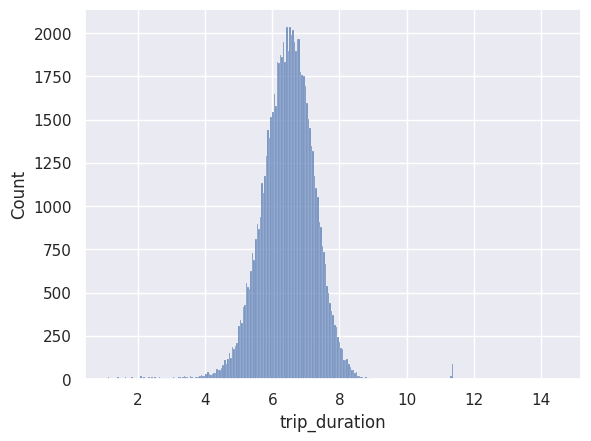

In [ ]:
sns.set(style='darkgrid')
sns.histplot(data=y_train_log)
plt.show()

In [ ]:
y = y_train_log

Чтобы иметь некоторую точку отсчета, давайте посчитаем значение метрики при наилучшем константном предсказании:

In [ ]:
def rmsle(log1p_y_true, log1p_y_pred):
    return np.sqrt(np.sum((log1p_y_true - log1p_y_pred)**2) / len(log1p_y_pred))

# поскольку это аналог mse, нужно взять аналог среднего - среднее среди у с крышкой

rmsle_best_const = rmsle(y, np.full(len(y), np.exp(np.log(y.mean()))))

# rmsle_best_const = rmsle(y_train, np.full(len(y_train), np.exp(np.log(y_old.mean()))))
print(rmsle_best_const)
assert np.allclose(rmsle_best_const, 0.79575, 1)

0.7954068740293178


In [ ]:
# assert 1e-4 сработал, когда я использовал всю обучающую выборку
# если он не будет работать - дело в семплировании]

## Часть 1. Изучаем `pickup_datetime` (2 балла)

**Задание 2 (0.25 баллов)**. Для начала давайте посмотрим, сколько всего было поездок в каждый из дней. Постройте график зависимости количества поездок от дня в году (например, можно воспользоваться `sns.countplot`):

In [ ]:
X['dayofyear'] = X['pickup_datetime'].dt.dayofyear
X['hora'] = X['pickup_datetime'].dt.hour
X['dayofweek'] = X['pickup_datetime'].dt.dayofweek
X['month'] = X['pickup_datetime'].dt.month

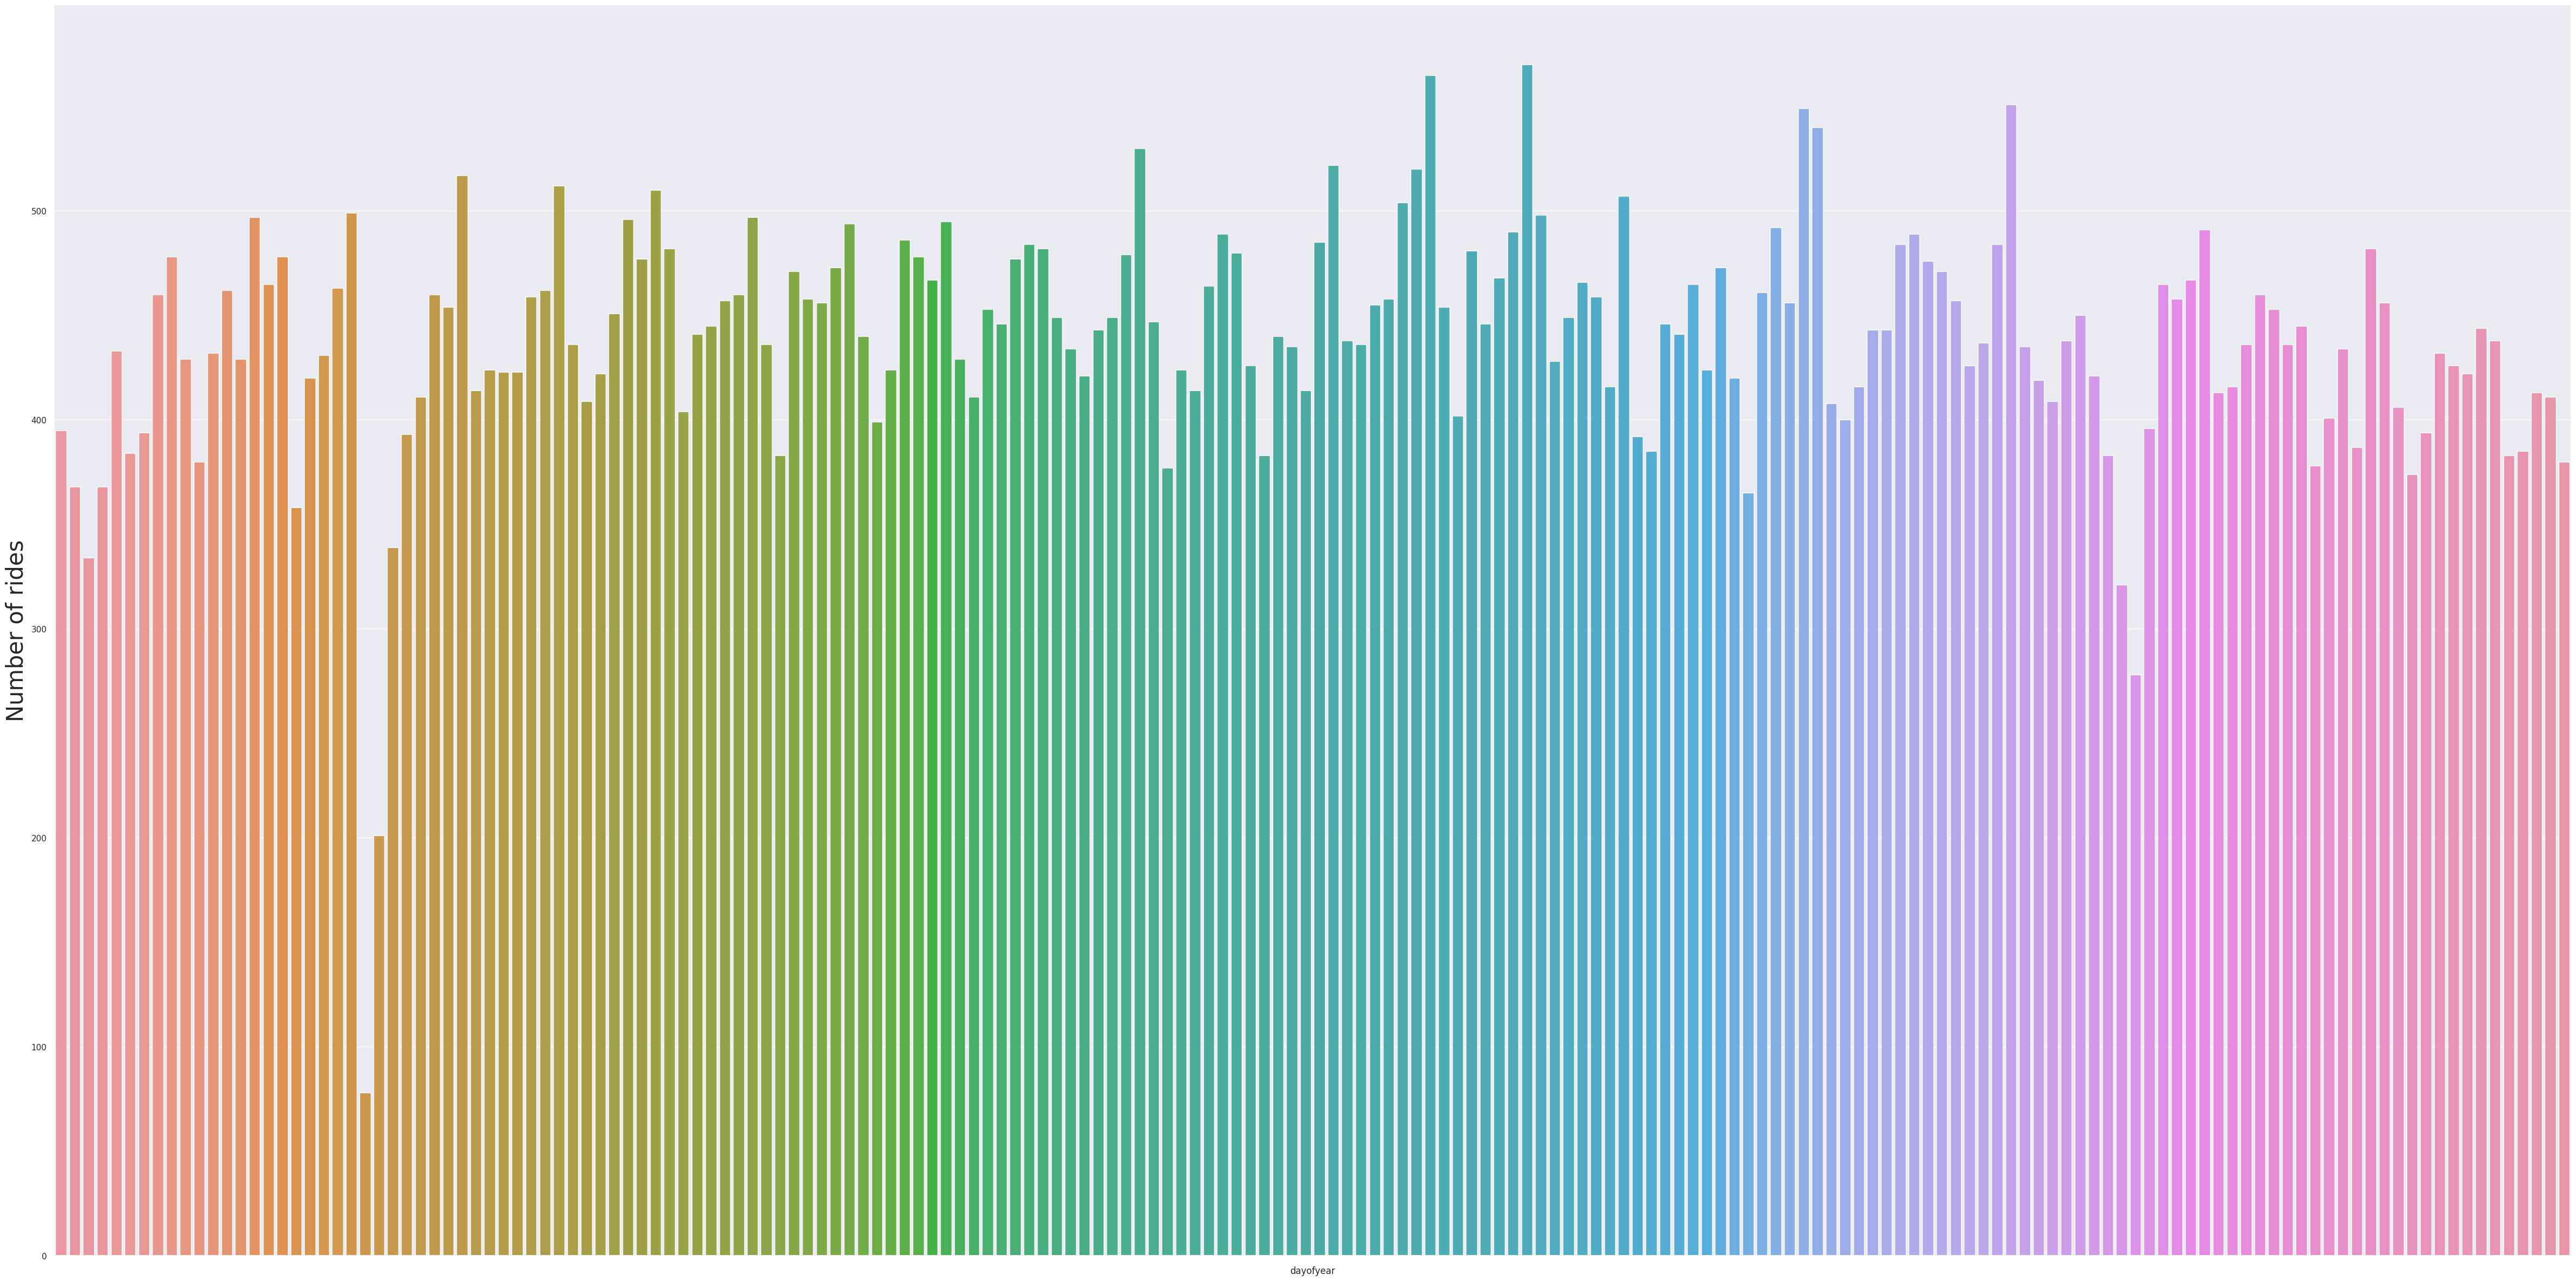

In [ ]:
plt.figure(figsize=(60,30))
gr = sns.countplot(x = X['dayofyear'])
plt.ylabel('Number of rides', fontsize=30)
sns.set(font_scale = 1)

# чтобы увидеть дни, нужно убрать эту строчку. Я увидел, что аномалии были 23
# января и 30 мая, поэтому уберу подписи дней, чтобы график был красивее
gr.set(xticklabels=[])

print('')

**Вопрос**: Вы, вероятно, заметили, что на графике есть 2 периода с аномально маленькими количествами поездок. Вычислите, в какие даты происходили эти скачки вниз и найдите информацию о том, что происходило в эти дни в Нью-Йорке.


**23 января власти штата ограничили движение из-за снежной бури**

https://ria.ru/20160123/1364032228.html

**30 мая произошло Х**


Нарисуйте графики зависимости количества поездок от дня недели и от часов в сутках (воспользуйтесь `sns.relplot`):

In [ ]:
weekdays_avg = X.groupby(X['hora']).count()
weekdays_avg.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofyear,dayofweek,month
hora,,,,,,,,,,,,
0,2953,2953,2953,2953,2953,2953,2953,2953,2953,2953,2953,2953
1,2156,2156,2156,2156,2156,2156,2156,2156,2156,2156,2156,2156
2,1522,1522,1522,1522,1522,1522,1522,1522,1522,1522,1522,1522
3,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194,1194
4,872,872,872,872,872,872,872,872,872,872,872,872


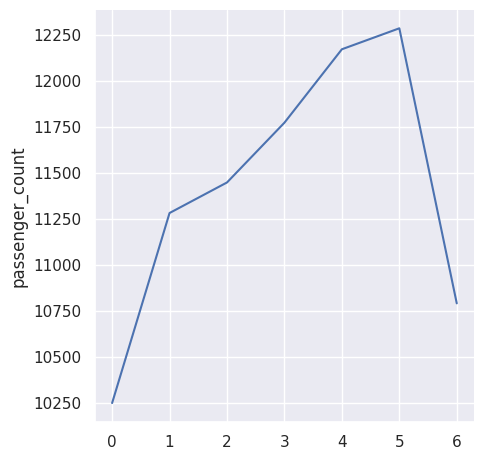

In [ ]:
weekdays_avg = X.groupby(X['dayofweek']).count()
sns.relplot(data=weekdays_avg, x = range(7), y = 'passenger_count', kind='line')

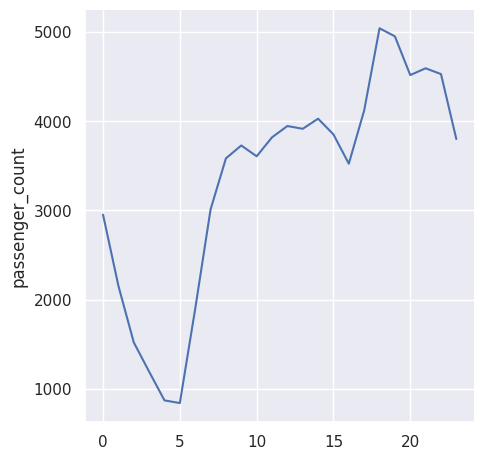

In [ ]:
hours_avg = X.groupby(X['pickup_datetime'].dt.hour).count()
sns.relplot(data=hours_avg, x = range(24), y = 'passenger_count', kind='line')

**Задание 3 (0.5 баллов)**. Нарисуйте на одном графике зависимости количества поездок от часа в сутках для разных месяцев (разные кривые, соответствующие разным месяцам, окрашивайте в разные цвета, воспользуйтесь `hue` в `sns.relplot`). Аналогично нарисуйте зависимости количества поездок от часа в сутках для разных дней недели.

<Axes: xlabel='hora', ylabel='Count'>

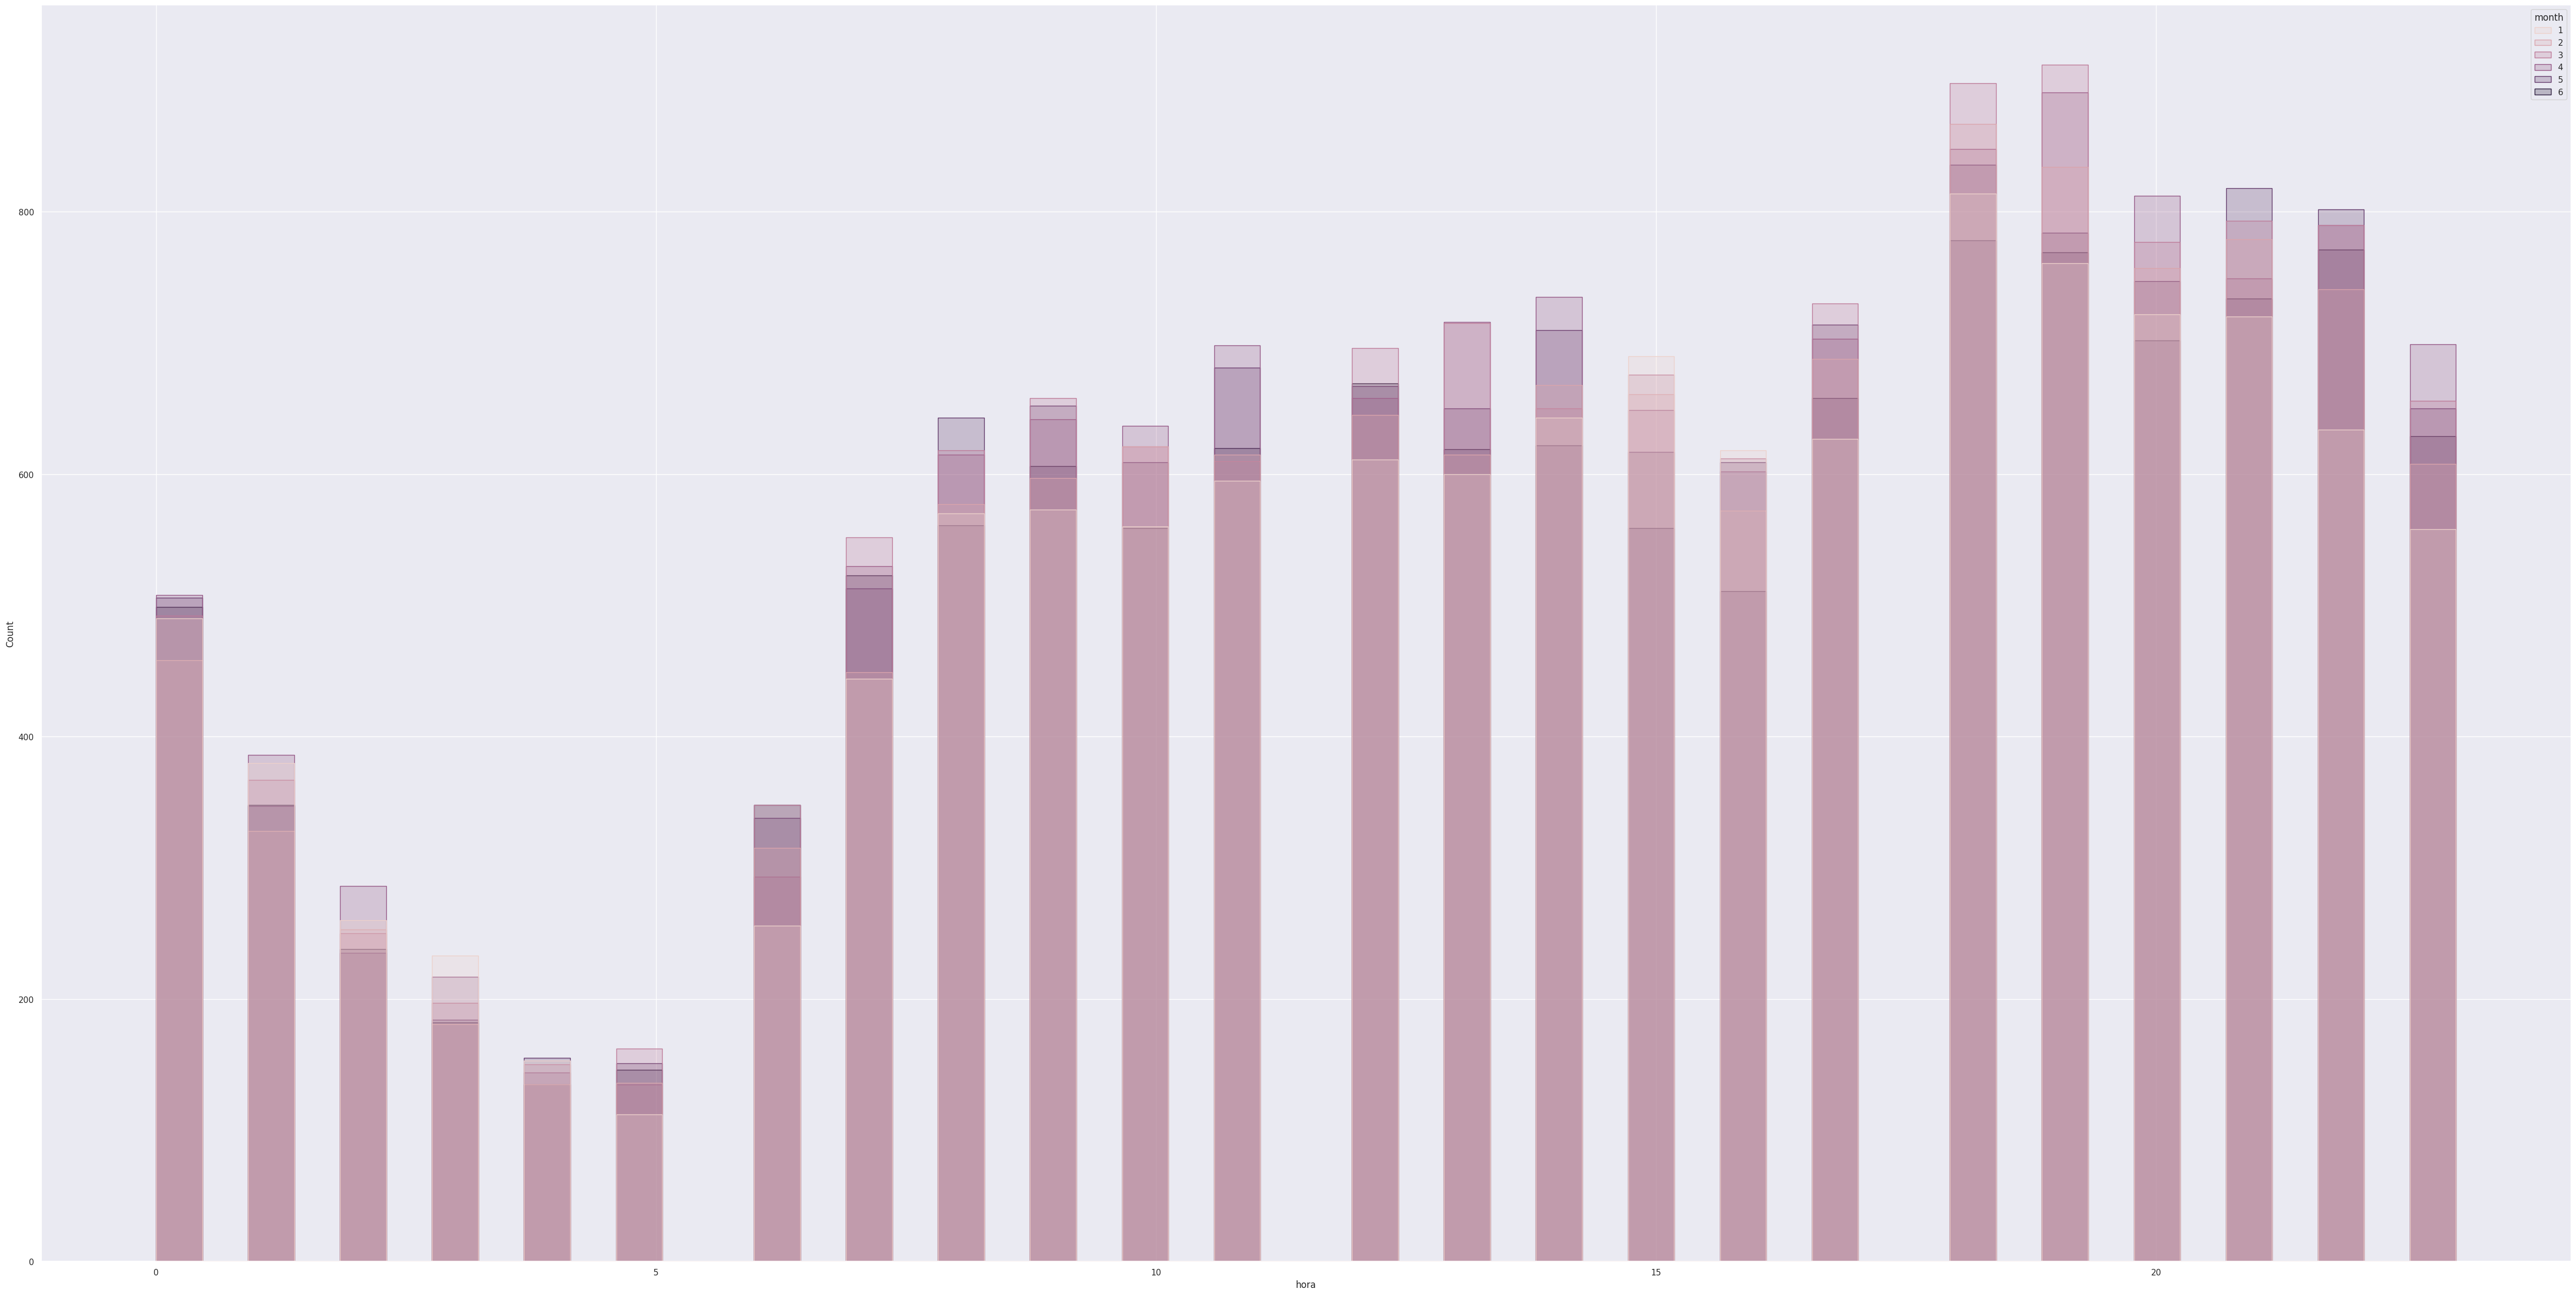

In [ ]:
plt.figure(figsize=(60,30))
sns.histplot(data=X, x='hora', hue='month', element="step")

<Axes: xlabel='hora', ylabel='Count'>

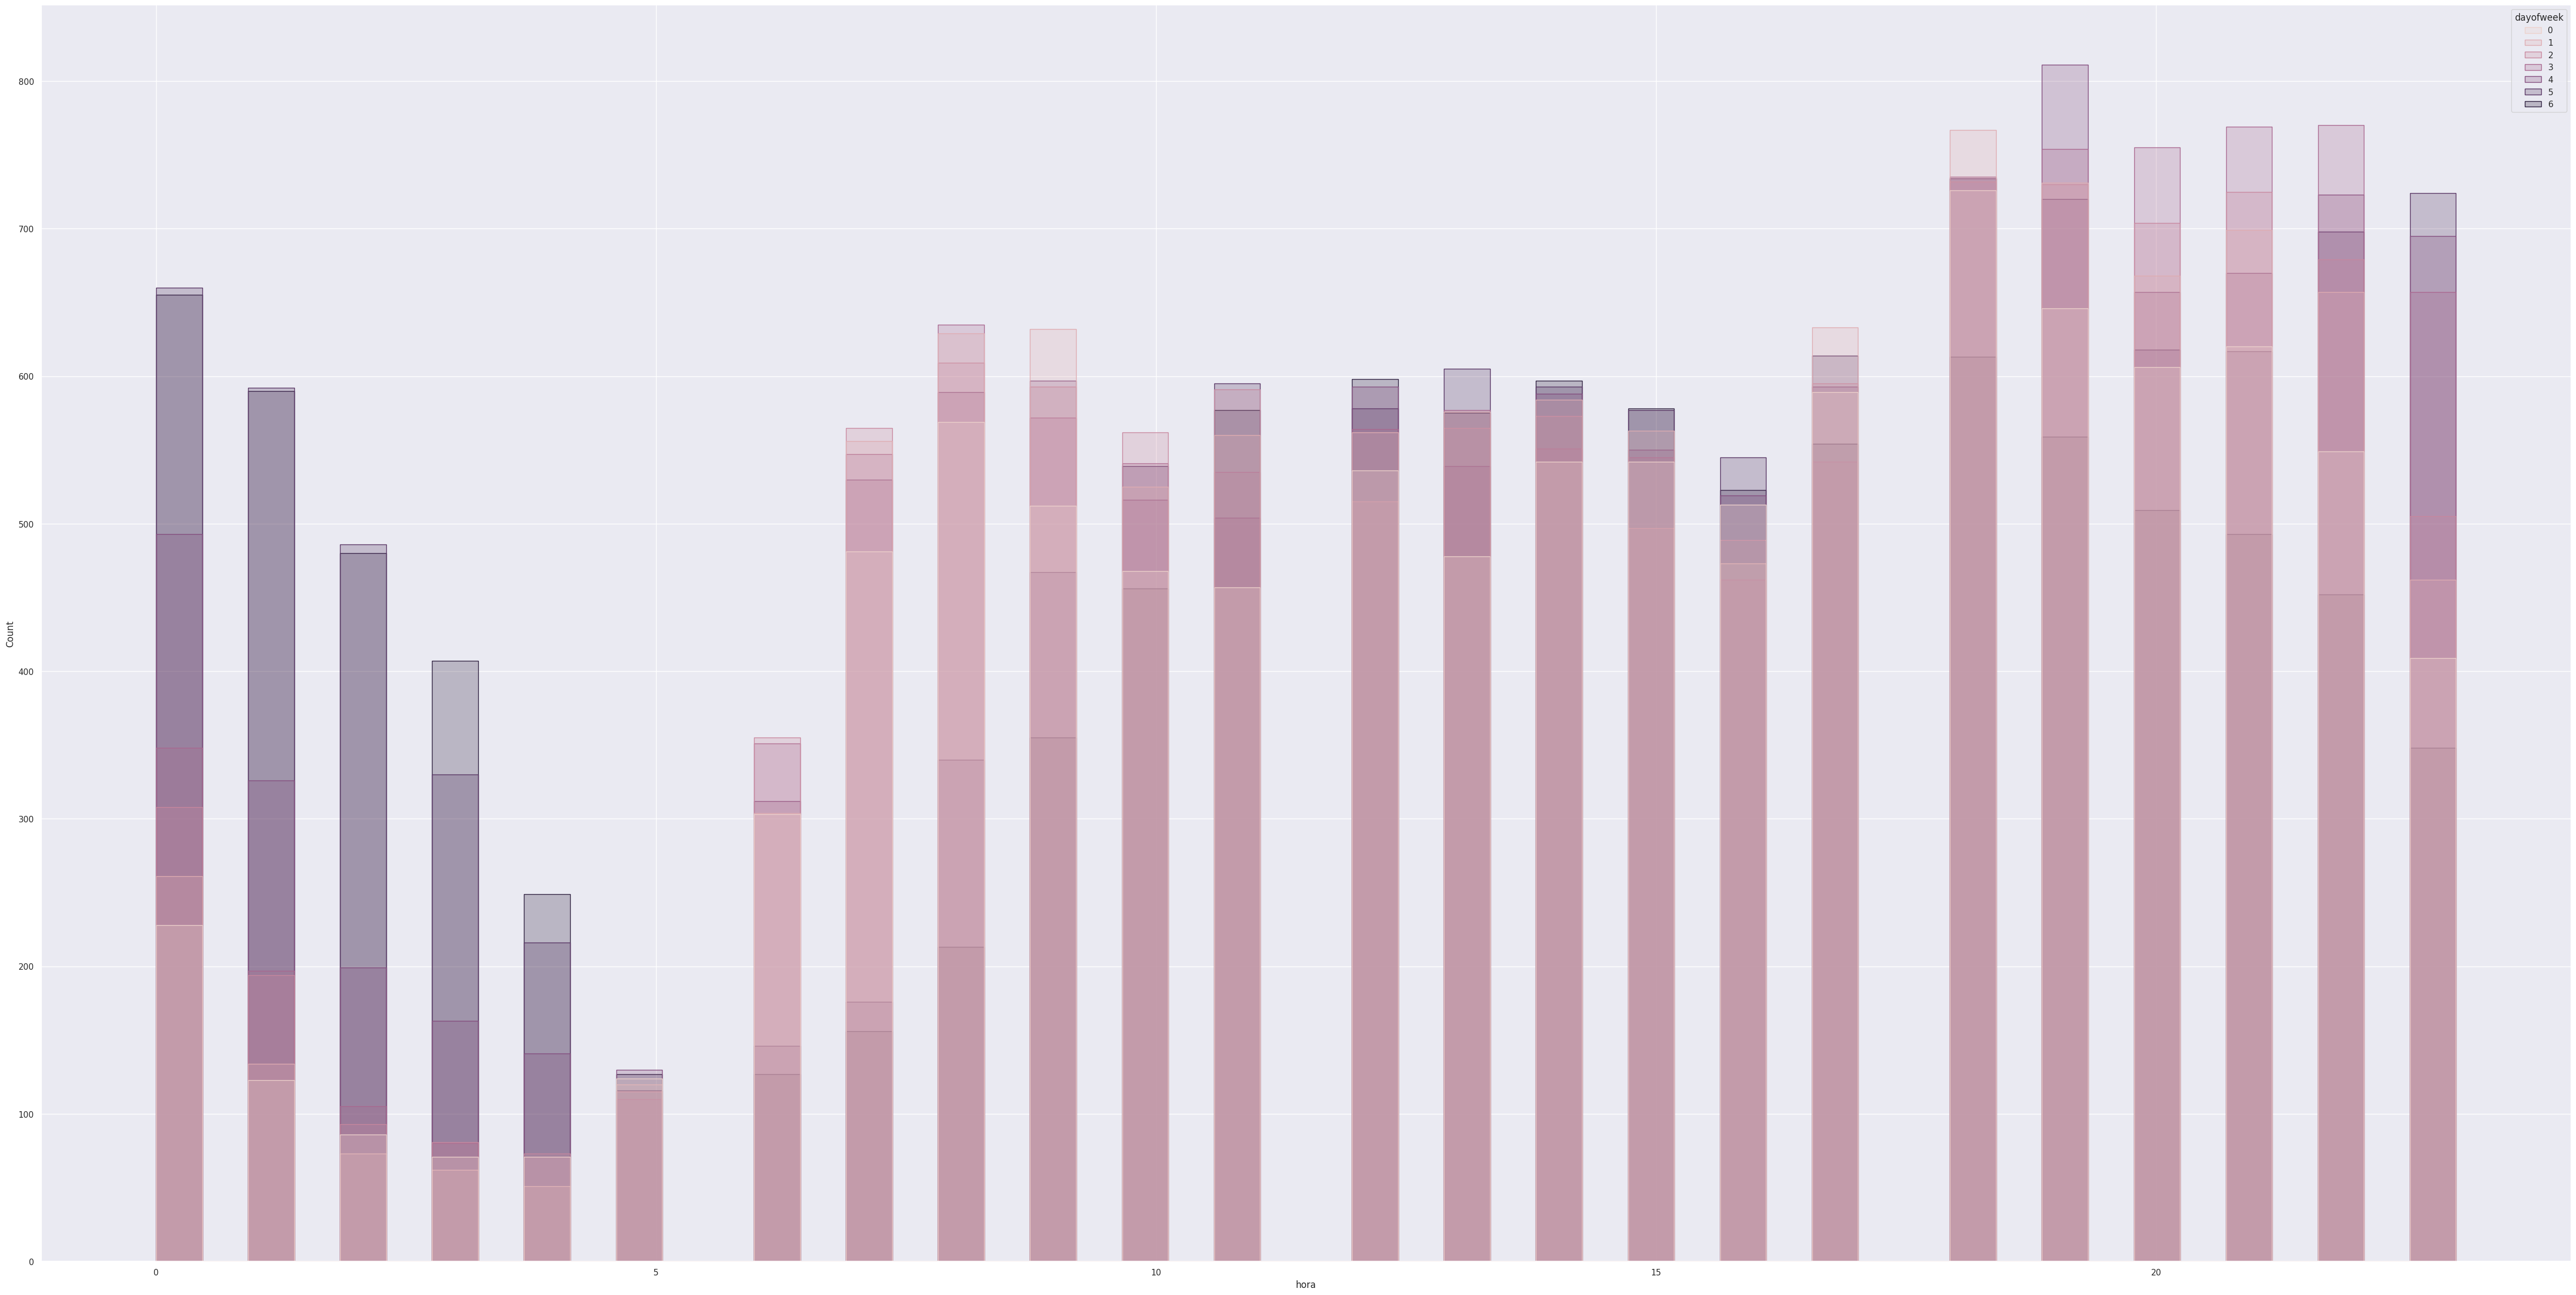

In [ ]:
plt.figure(figsize=(60,30))
sns.histplot(data=X, x='hora', hue='dayofweek', element="step")

**Вопрос**: Какие выводы можно сделать, основываясь на графиках выше? Выделяются ли какие-нибудь дни недели? Месяца? Время суток? С чем это связано?

In [ ]:
# В разные месяцы графики практически совпадают, значимой разницы нет

# По субботам и воскресеньям люди ездят на такси НОЧЬЮ сильно чаще, чем в будние дни
# В утренний час-пик - наоборот, в выходные реже
# По выходным все тусуются, а в будние спят, чтобы рано утром поехать на работу :(

# В целом чаще всего поездки происходят вечером, ночью - реже. Пиковые часы - 8-9 утра и 18-20 вечера
# Тут тоже логично: утром  едут на работу (причем не все, некоторые едут на своих машинах или общественном транспорте),
# а вот вееечером такси используется совсем часто



**Задание 4 (0.5 баллов)**. Разбейте выборку на обучающую и тестовую в отношении 7:3 (используйте `train_test_split` из `sklearn`). По обучающей выборке нарисуйте график зависимости среднего логарифма времени поездки от дня недели. Затем сделайте то же самое, но для часа в сутках и дня в году.

In [ ]:
# Сначала я выведу графики, а потом разобью на трейн и тест

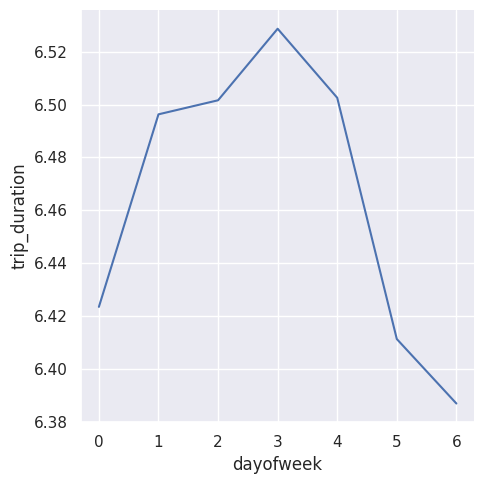

In [ ]:
sns.relplot(x = X['dayofweek'], y = y, kind = 'line', errorbar=None)
print('')

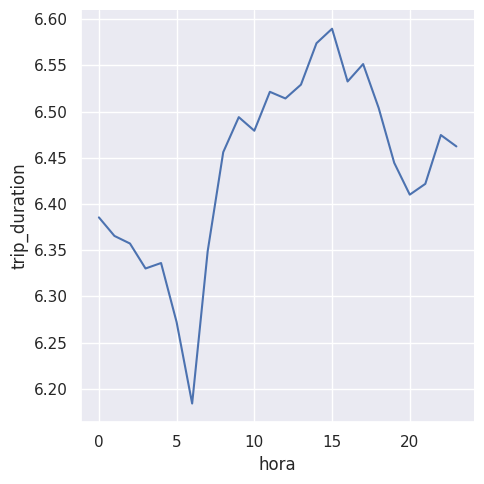

In [ ]:
sns.relplot(x = X['hora'], y = y, kind = 'line', errorbar=None)
print('')


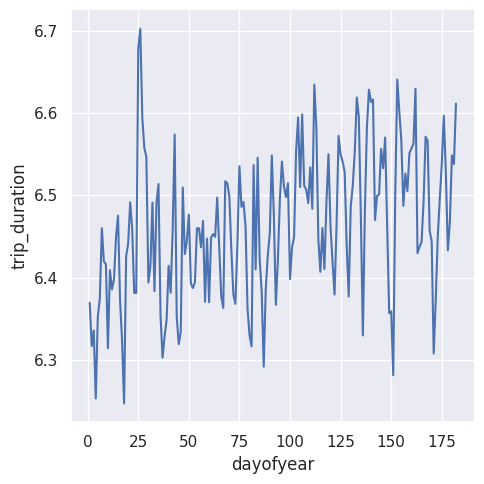

In [ ]:
sns.relplot(x = X['dayofyear'], y = y, kind = 'line', errorbar=None)
print('')

**Вопрос**: Похожи ли графики зависимости таргета от дня недели и от часа в сутках на аналогичные графики для количества поездок? Почему? Что происходит со средним таргетом в те два аномальных периода, что мы видели выше? Почему так происходит? Наблюдаете ли вы какой-нибудь тренд на графике зависимости `log_trip_duration` от номера дня в году?

In [ ]:
# Пробки)
# Я сейчас чувствую себя Эйнштейном, хотя я явно не он, потому что мне
# для ответа на первый вопрос пришлось сначала ответить на вопрос про аномалии.
# Ночью пробок нет, потому что ночью меньше поездок (и на такси, и вообще).
# В часы пик продолжительность поездки будет больше, потому что город кишит машинами

# В первый аномальный период продолжительность подскочила, потому что из-за снега
# весь город стоял в пробках

# Во второй период таргет тоже вырос - причину я пока не определил, потому что
# не определил источник аномалии

# Тренд есть - он восходящий, интуицию уловить сложно, но возможно, что чем ближе
# к лету, тем больше в городе людей - и местных, и туристов. Больше людей - больше пробок,
# больше пробок - больше таргет

# Цикличность вызвана наложением на график выведенного ранее паттерна "много пробок в будние, мало - в выходные"

Добавьте следующие признаки на основе `pickup_datetime`:
1. День недели
2. Месяц
3. Час
4. Является ли период аномальным (два бинарных признака, соответствующие двум аномальным периодам)
5. Номер дня в году

In [ ]:
X['John_snow'] = np.where(X['dayofyear'] == 23, True, False).astype(int)
X['Unknown_mystery'] = np.where(X['dayofyear'] == 151, True, False).astype(int)


Итак, мы уже создали некоторое количество признаков.

**Вопрос**: Какие из признаков _стоит рассматривать в этой задаче_   как категориальные, а какие - как численные? Почему?

In [ ]:
# День недели, номер в году, месяц и час в целом можно рассматривать как численные,
# потому что они уже переведены в нужный формат и из-за того, что они упорядочены
# То есть скоррелированность целевой переменной с такой фичей будет иметь смысл:
# это не рандомные циферки, а значения с обоснованием

# Джон Сноу и неизвестная загадка - численные, тк булевы

In [ ]:
X.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,dayofyear,hora,dayofweek,month,John_snow,Unknown_mystery
1457636,id0880738,2,2016-02-27 20:13:05,1,-73.981728,40.749500,-73.945915,40.792061,N,58,20,5,2,0,0
615369,id2002545,2,2016-06-04 09:54:05,1,-73.979088,40.771606,-73.946518,40.822655,N,156,9,5,6,0,0
491096,id0289724,2,2016-05-06 17:40:05,1,-73.989700,40.738651,-73.997772,40.754051,N,127,17,4,5,0,0
82632,id3767649,2,2016-05-30 19:20:26,1,-73.988441,40.723267,-73.995880,40.716717,N,151,19,0,5,0,1
71403,id2530846,2,2016-01-19 14:19:22,2,-73.985733,40.752598,-73.969231,40.755997,N,19,14,1,1,0,0


In [ ]:
# Вот теперь пора!

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

**Задание 5 (0.75 баллов)**. Обучите `Ridge`-регрессию с параметрами по умолчанию, закодировав все категориальные признаки с помощью `OneHotEncoder`. Численные признаки отмасштабируйте с помощью `StandardScaler`. Используйте только признаки, которые мы выделили в этой части задания.

In [ ]:
from sklearn.linear_model import Ridge
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X6_train = scaler.fit_transform(X_train.iloc[:, -6:])
X6_test = scaler.transform(X_test.iloc[:, -6:])

rr = Ridge()
rr.fit(X6_train, y_train)
y_pred = rr.predict(X6_test)
rmsle(y_pred, y_test)

0.7920312789105948

In [ ]:
# напоминает домашку по глубокому обучению: я мастерски обыгрываю константу
# и набираю лосс больше нее)))

## Часть 2. Изучаем координаты (3 балла)
Мы уже очень хорошо изучили данные о времени начала поездки, давайте теперь посмотрим на информацию о координатах начала и конца поездки. Мы подготовили для вас функцию, которая на карте рисует точки начала или конца поездки. Примеры ее вызова вы найдете ниже. Обратите внимание, что в эту функцию мы передаем лишь небольшой кусочек данных, посколько иначе функция будет работать очень долго

In [ ]:
def show_circles_on_map(data, latitude_column, longitude_column, color):
    '''
    The function draws map with circles on it.
    The center of the map is the mean of coordinates passed in data.

    data: DataFrame that contains columns latitude_column and longitude_column
    latitude_column: string, the name of column for latitude coordinates
    longitude_column: string, the name of column for longitude coordinates
    color: string, the color of circles to be drawn
    '''

    location = (data[latitude_column].mean(), data[longitude_column].mean())
    m = folium.Map(location=location, width=600,height=600)

    for _, row in data.iterrows():
        folium.Circle(
            radius=50,
            location=(row[latitude_column], row[longitude_column]),
            color=color,
            fill_color=color,
            fill=True
        ).add_to(m)

    return m

In [ ]:
show_circles_on_map(df.sample(1000), 'pickup_latitude', 'pickup_longitude', 'blue')

In [ ]:
show_circles_on_map(df.sample(1000), 'dropoff_latitude', 'dropoff_longitude', 'blue')

**Вопрос**: Какие пункты (или скопления точек, в количестве 2-3), по вашему мнению, выделяются на карте от основной массы и могут быть полезны для нашей задачи? Почему вы их выбрали? В чём особенность этих скоплений точек для нашей задачи?

In [ ]:
# Капец манхэттен синий

# Выделяются перекрестки со СВЕТОФОРАМИ - пересечения крупных улиц и авеню
# Их особенность заключается в том, что на них удобно ловить такси, так как
# кэб некоторое время стои перед светофором и его видят люди.
# Плюс из-за трафика там много людей и много машин (в т.ч. такси)

**Задание 6 (0.75 балл)**. Как мы все прекрасно помним, $t = s / v_{\text{ср}}$, поэтому очевидно, что самым сильным признаком будет расстояние, которое необходимо проехать. Мы не можем посчитать точное расстояние, которое необходимо преодолеть такси, но мы можем его оценить, посчитав кратчайшее расстояние между точками начала и конца поездки. Чтобы корректно посчитать расстояние между двумя точками на Земле, можно использовать функцию `haversine`. Также можно воспользоваться кодом с первого семинара. Посчитайте кратчайшее расстояние для объектов и запишите его в колонку `haversine`:

In [ ]:
# Это код с первого семинара

In [ ]:
def dist(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

X_train['haversine'] = dist(X_train['pickup_latitude'].values, X_train['pickup_longitude'].values, X_train['dropoff_latitude'].values, X_train['dropoff_longitude'].values)
X_test['haversine'] = dist(X_test['pickup_latitude'].values, X_test['pickup_longitude'].values, X_test['dropoff_latitude'].values, X_test['dropoff_longitude'].values)

Так как мы предсказываем логарифм времени поездки и хотим, чтобы наши признаки были линейно зависимы с этой целевой переменной, нам нужно логарифмировать расстояние: $\log t = \log s - \log{v_{\text{ср}}}$. Запишите логарифм `haversine` в отдельную колонку `log_haversine`:

In [ ]:
X_train['log_haversine'] = np.log1p(X_train['haversine'])
X_test['log_haversine'] = np.log1p(X_test['haversine'])

Убедимся, что логарифм расстояния лучше коррелирует с нашим таргетом, чем просто расстояние:

In [ ]:
your_df = X_train
assert your_df['log_haversine'].corr(y_train) > your_df['haversine'].corr(y_train)

**Задание 7 (0.75 балла)**. Давайте изучим среднюю скорость движения такси. Посчитайте среднюю скорость для каждого объекта обучающей выборки, разделив `haversine` на `trip_duration`, и нарисуйте гистограмму ее распределения

In [ ]:
X_train['average_speed'] = X_train['haversine']/y_train

<Axes: xlabel='average_speed', ylabel='Count'>

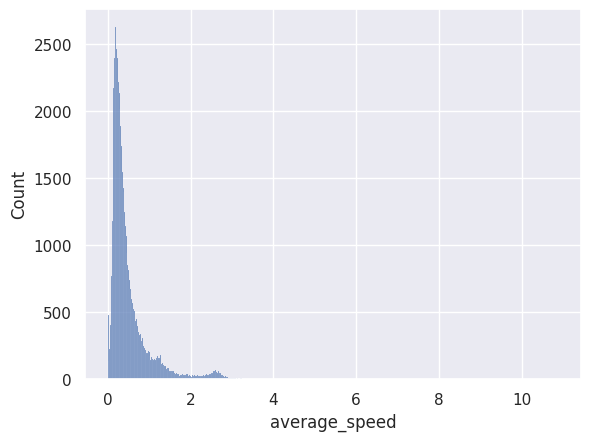

In [ ]:
sns.histplot(data = X_train['average_speed'])

Как можно видеть по гистограмме, для некоторых объектов у нас получились очень больше значения скоростей. Нарисуйте гистограмму по объектам, для которых значение скорости получилось разумным (например, можно не включать рассмотрение объекты, где скорость больше некоторой квантили):

<Axes: ylabel='Count'>

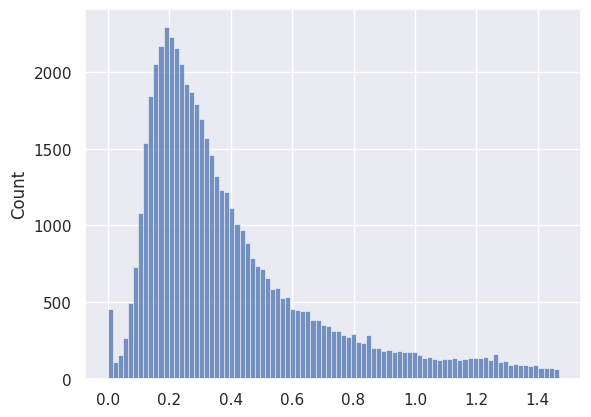

In [ ]:
sns.histplot(data = sorted(list(X_train['average_speed']))[:int(len(X_train)*0.95)])

Для каждой пары (день недели, час суток) посчитайте медиану скоростей. Нарисуйте с помощью `sns.heatmap` график, где по осям будут дни недели и часы, а в качестве значения функции - медиана скорости

In [ ]:
pivo = X_train.pivot_table(index = 'dayofweek', columns = 'hora', values = 'average_speed', aggfunc='median')
pivo

hora,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
dayofweek,,,,,,,,,,,,,,,,,,,,,
0,0.485058,0.577762,0.435723,0.587879,0.847350,0.643296,0.370835,0.317680,0.299161,0.280284,...,0.302713,0.292496,0.298255,0.307245,0.302854,0.314924,0.340524,0.399073,0.377247,0.431083
1,0.440410,0.447705,0.538986,0.466804,0.506915,0.437626,0.363217,0.330267,0.267438,0.284942,...,0.296371,0.275168,0.300690,0.300246,0.296951,0.313091,0.384068,0.389879,0.397384,0.408006
2,0.487427,0.487276,0.522753,0.357006,0.574163,0.413461,0.344416,0.334166,0.280448,0.280144,...,0.282739,0.275103,0.281242,0.301890,0.283285,0.311617,0.345142,0.389698,0.379584,0.396437
3,0.398936,0.439262,0.538756,0.438980,0.423820,0.493595,0.311901,0.308969,0.280306,0.286128,...,0.301037,0.265483,0.281418,0.285742,0.300915,0.291330,0.353580,0.366228,0.384009,0.426448
4,0.433341,0.413245,0.477230,0.570420,0.414764,0.450560,0.421880,0.326187,0.294651,0.272169,...,0.301971,0.299567,0.284426,0.286471,0.298137,0.301567,0.310996,0.344977,0.338096,0.368155
5,0.396274,0.391177,0.475042,0.486764,0.577479,0.679588,0.432561,0.396548,0.322172,0.310485,...,0.305015,0.311874,0.325754,0.316138,0.309873,0.282029,0.313614,0.315825,0.356581,0.360845
6,0.360022,0.381173,0.447855,0.447028,0.480716,0.561184,0.597069,0.410681,0.358121,0.374507,...,0.303009,0.320790,0.333971,0.350714,0.356524,0.342057,0.342033,0.387013,0.406293,0.459635


<Axes: xlabel='hora', ylabel='dayofweek'>

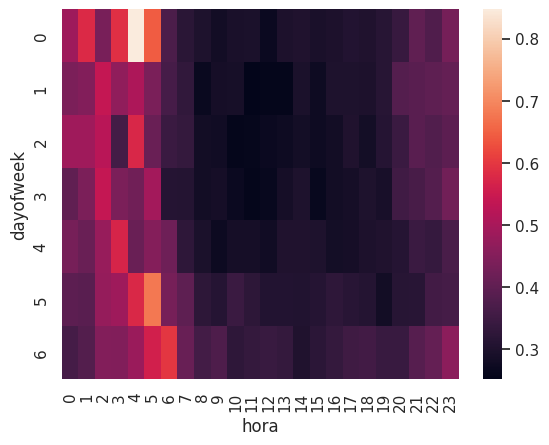

In [ ]:
sns.heatmap(pivo)

Не забудьте удалить колонку со значением скорости из данных!


In [ ]:
X_train = X_train.drop('average_speed', axis = 1)


**Вопрос**: Почему значение скорости нельзя использовать во время обучения?

In [ ]:
# Потому что v*t = s
# У нас уже есть s среди признаков, если добавить v, то наша
# модель может делать предсказания с точностью 100% и без всего остального

# Приятный бонус: в жизни у нас средней скорости не будет (опять же,
# если будет, то сама модель не нужна)

**Вопрос**: Посмотрите внимательно на график и скажите, в какие моменты времени скорость минимальна; максимальна.

In [ ]:
# Скорость максимальна ночью, когда дороги пустые,
# и минимальна в часы-пик днем. Интересно, что скорость по
# тенденции связана с таргетом: в выходные она выше, потому что
# пробок меньше



Создайте признаки 'поездка совершается в период пробок' и 'поездка совершается в период свободных дорог' (естественно, они не должен зависеть от скорости!):

In [ ]:
# Чтобы сильно не выпендриваться, я возьму за "период пробок" время с 8 до 19
X_train['Traffic'] = np.where((X_train['hora'] >= 8) & (X_train['hora'] <= 19), True, False).astype(int)

X_test['Traffic'] = np.where((X_test['hora'] >= 8) & (X_test['hora'] <= 19), True, False).astype(int)
# И за период их отсутствия всё остальное время

**Задание 8 (0.25 балла)**. Для каждого из замеченных вами выше 2-3 пунктов добавьте в выборку по два признака:
- началась ли поездка в этом пункте
- закончилась ли поездка в этом пункте

Как вы думаете, почему эти признаки могут быть полезны?

Для каждого из созданных признаков нарисуйте 'ящик с усами' (`sns.boxplot`) распределения логарифма времени поездки

<Axes: xlabel='Traffic', ylabel='trip_duration'>

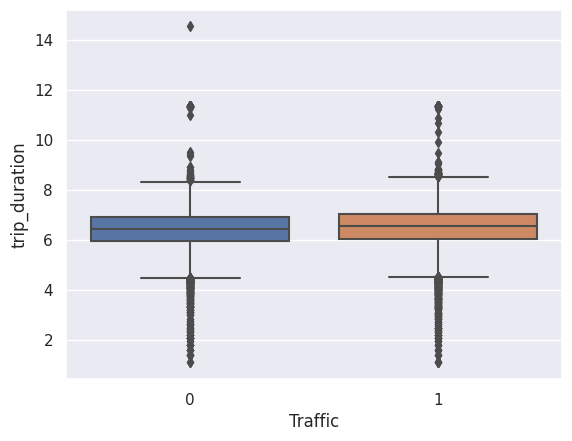

In [ ]:
sns.boxplot(x = X_train['Traffic'], y = y_train)

**Вопрос**: судя по графикам, как вы думаете, хорошими ли получились эти признаки?

In [ ]:
# Фигня какая-то, разница есть, но мизерная

<img src='https://www.dropbox.com/s/xson9nukz5hba7c/map.png?raw=1' align='right' width='20%' style='margin-left: 20px; margin-bottom: 20px'>

**Задание 9 (1 балл)**. Сейчас мы почти что не используем сами значения координат. На это есть несколько причин: по отдельности рассматривать широту и долготу не имеет особого смысла, стоит рассматривать их вместе. Во-вторых, понятно, что зависимость между нашим таргетом и координатами не линейная. Чтобы как-то использовать координаты, можно прибегнуть к следующему трюку: обрамим область с наибольшим количеством поездок прямоугольником (как на рисунке). Разобьем этот прямоугольник на ячейки. Каждой точке сопоставим номер ее ячейки, а тем точкам, что не попали ни в одну из ячеек, сопоставим значение -1.

Напишите трансформер, который сначала разбивает показанную на рисунке область на ячейки, а затем создает два признака: номер ячейки, в которой началась поездка, и номер ячейки, в которой закончилась поездка. Количество строк и столбцов выберите самостоятельно.

Обратите внимание, что все вычисления должны быть векторизованными, трансформер не должен модифицировать передаваемую ему выборку inplace, а все необходимые статистики (если они вдруг нужны) нужно считать только по обучающей выборке в методе `fit`:

In [ ]:
n = len(X_train['pickup_latitude'])
# m - сторона квадрата
m = 5
lat_inf, lat_sup = sorted(list(X_train['pickup_latitude']))[int(0.1*n)], sorted(list(X_train['pickup_latitude']))[int(0.9*n)]
lng_inf, lng_sup = sorted(list(X_train['pickup_longitude']))[int(0.1*n)], sorted(list(X_train['pickup_longitude']))[int(0.9*n)]
step_lat = (lat_sup - lat_inf) / m
step_lng = (lng_sup - lng_inf) / m

X_train['location_lat'] = ((X_train['pickup_latitude'] - lat_inf) // step_lat).astype(int)
X_train['location_lng'] = ((X_train['pickup_longitude'] - lng_inf) // step_lng).astype(int)
X_train.loc[X_train['location_lat'] > 5, 'location_lat'] = 5
X_train.loc[X_train['location_lat'] < 0, 'location_lat'] = 0
X_train.loc[X_train['location_lng'] > 5, 'location_lng'] = 5
X_train.loc[X_train['location_lng'] < 0, 'location_lng'] = 0

X_train['location'] = X_train['location_lat'].astype(str) + X_train['location_lng'].astype(str)

X_train = X_train.drop(['location_lat', 'location_lng'], axis = 1)

In [ ]:
X_test['location_lat'] = ((X_test['pickup_latitude'] - lat_inf) // step_lat).astype(int)
X_test['location_lng'] = ((X_test['pickup_longitude'] - lng_inf) // step_lng).astype(int)
X_test.loc[X_test['location_lat'] > 5, 'location_lat'] = 5
X_test.loc[X_test['location_lat'] < 0, 'location_lat'] = 0
X_test.loc[X_test['location_lng'] > 5, 'location_lng'] = 5
X_test.loc[X_test['location_lng'] < 0, 'location_lng'] = 0

X_test['location'] = X_test['location_lat'].astype(str) + X_test['location_lng'].astype(str)

X_test = X_test.drop(['location_lat', 'location_lng'], axis = 1)

In [ ]:
# Я экономист, поэтому не понял задание и сделал по-своему
# Я выделил адекватные нижнюю и верхнюю границы широты и долготы и разбил
# все наблюдения на 25 квадратов. Ниже я их перевел через ohe и получил то же, но
# чуть проще и не так элегантно

**Задание 10 (0.25 балла)**. Обучите `Ridge`-регрессию со стандартными параметрами на признаках, которые мы выделили к текущему моменту. Категориальные признаки закодируйте через one-hot-кодирование, числовые признаки отмасштабируйте.

In [ ]:
X_train.iloc[:, -10:]

,dayofyear,hora,dayofweek,month,John_snow,Unknown_mystery,haversine,log_haversine,Traffic,location
894928,170,15,5,6,0,0,1.108886,0.746160,1,20
549012,43,21,4,2,0,0,1.253227,0.812363,0,31
410757,178,2,6,6,0,0,1.238458,0.805787,0,12
897934,71,14,4,3,0,0,1.193854,0.785660,1,10
1450449,77,20,3,3,0,0,7.110063,2.093106,0,00
...,...,...,...,...,...,...,...,...,...,...
917589,106,23,4,4,0,0,6.697948,2.040954,0,11
795892,171,1,6,6,0,0,3.471813,1.497794,0,01
93896,172,14,0,6,0,0,3.307308,1.460313,1,21
1322909,62,8,2,3,0,0,1.250432,0.811122,1,41


In [ ]:
X_ttt = pd.get_dummies(X_train.iloc[:, -10:])
X_tttest = pd.get_dummies(X_test.iloc[:, -10:])
rrr = Ridge()
rrr.fit(X_ttt, y_train)
y_prrred = rrr.predict(X_tttest)

rmsle(y_prrred, y_test)

0.5093175949664559

## Часть 3. Изучаем оставшиеся признаки (1 балл)

**Задание 11 (0.75 баллов)**. У нас осталось еще 3 признака, которые мы не исследовали: `vendor_id`, `passenger_count` и `store_and_fwd_flag`.

**Вопрос**: Подумайте, почему каждый из этих признаков может быть потенциально полезным.

Посчитайте, сколько есть уникальных значений у каждого из этих признаков:

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Постройте 'ящики с усами' распределений логарифма времени поездки в зависимости от значений каждого из признаков

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Переведите признаки `vendor_id` и `store_and_fwd_flag` в значения $\{0;1\}$

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Вопрос**: Основываясь на графиках выше, как вы думаете, будут ли эти признаки сильными?

**Задание 12 (0.25 баллов)**. Проверьте свои предположения, обучив модель в том числе и на этих трех признаках. Обучайте `Ridge`-регрессию со стандартными параметрами. Категориальные признаки закодируйте one-hot-кодированием, а численные отмасштабируйте.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Если признаки не дали какого-то ощутимого улучшения метрики, их можно выбросить из данных.

## Часть 4. Улучшаем модель (3 балла)

**Задание 13 (1 балл)**. В наших данных есть нетипичные объекты (выбросы, или outliers): с аномально маленьким времени поездки, с очень большим пройденным расстоянием или очень большими остатками регрессии. В этом задании предлагается исключить такие объекты из обучающей выборки. Для этого нарисуйте гистограммы распределения упомянутых выше величин, выберите объекты, которые можно назвать выбросами, и очистите __обучающую выборку__ от них.

Отметим, что хотя эти объекты и выглядят как выбросы, в тестовой выборке тоже скорее всего будут объекты с такими же странными значениями целевой переменной и/или признаков. Поэтому, возможно, чистка обучающей выборки приведёт к ухудшению качества на тесте. Тем не менее, всё равно лучше удалять выбросы из обучения, чтобы модель получалась более разумной и интерпретируемой.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Сейчас у нас очень много категориальных признаков. В категориальных признаках могут содержаться редкие категории, обычно это плохо: модель сильно переобучается на таких примерах. Для каждого категориального признака объедините действительно редкие категории в одну, если такие имеются (т.е. если категории действительно редкие).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Обучите модель на очищенных данных и посчитайте качество на тестовой выборке.

**Задание 14 (1 балл)**. После OneHot-кодирования количество признаков в нашем датасете сильно возрастает. Посчитайте колиество признаков до и после кодирования категориальных признаков.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Попробуйте обучить не `Ridge`-, а `Lasso`-регрессию. Какой метод лучше?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Разбейте _обучающую выборку_ на обучающую и валидационную в отношении 8:2. По валидационной выборке подберите оптимальные значения параметра регуляризации (по логарифмической сетке) для `Ridge` и `Lasso`, на тестовой выборке измерьте качество лучшей полученной модели.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Для каждого перебранного `alpha` для Lasso посчитайте количество нулевых весов в модели и нарисуйте график зависимости его от `alpha`. Как сильно придётся потерять в качестве, если мы хотим с помощью Lasso избавиться хотя бы от половины признаков?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

<img src='https://www.dropbox.com/s/wp4jj0599np17lh/map_direction.png?raw=1' width='20%' align='right' style='margin-left: 20px'>

**Задание 15 (1 балл)**. Часто бывает полезным использовать взаимодействия признаков (feature interactions), то есть строить новые признаки на основе уже существующих. Выше мы разбили карту Манхэттена на ячейки и придумали признаки 'из какой ячейки началась поездка' и 'в какой ячейке закончилась поездка'.

Давайте попробуем сделать следующее: посчитаем, сколько раз встречается каждая возможная пара этих признаков в нашем датасете и выберем 100 самых частых пар. Закодируем поездки с этими частыми парами как категориальный признак, остальным объектам припишем -1. Получается, что мы закодировали, откуда и куда должно было ехать такси.

Также можете придумать ещё какой-нибудь способ сделать признаки про маршрут. Если эти признаки будут давать хороший прирост в качестве, то за это могут быть даны дополнительные бонусные баллы.

**Вопрос**: Почему такой признак потенциально полезный? Почему линейная модель не может самостоятельно 'вытащить' эту информацию, ведь у нее в распоряжении есть признаки 'из какой ячейки началась поездка' и 'в какой ячейке закончилась поездка'?

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель (`Ridge`, если она дала более высокое качество в предыдущих экспериментах, и `Lasso` иначе) на новых даннных и посчитайте качество на тестовой выборке

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

**Задание 16 (бонус, 1 балл)**. Где, как не для нашей задачи, считать манхэттенское расстояние?

**Вопрос**: Найдите, что такое манхэттенское расстояние и почему оно так называется. Как оно нам может помочь?

Введите систему координат на нашей карте так, чтобы оси были параллельны улицам Манхэттена, и добавьте сначала в данные признак 'манхэттенское расстояние между пунктом отправления и пунктом назначения', а затем и логарифм этого признака. Посчитайте корреляцию между вашим новыми признаком и таргетом; между `log_haversine` и таргетом. В каком случае корреляция больше?

Нарисуйте карту, где покажете выбранные оси. Чтобы мы могли проверить вашу работу, просьба сделать скрин этой карты и приложить картинку (если мы откроем ваш ноутбук, виджеты отображаться не будут).

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Заново обучите модель на новых даннных и посчитайте качество на тестовой выборке. Стало ли лучше? Объясните полученный результат.

In [ ]:
#╰( ͡° ͜ʖ ͡° )つ──☆*:・ﾟ

Вставьте картинку, описывающую ваш опыт выполнения этого ДЗ.